In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from pypdf import PdfReader, PdfWriter
from sklearn.model_selection import train_test_split

import utils
from stock_plotter import StockPlotter
from models import Models
from model_evaluator import ModelEvaluator
from time_series_visualizer import TimeSeriesVisualizer
from backtest import BacktestStrategy
from xgb_model import XGBoostModel
from xgb_model_val import XGBoostModelVal
import pandas_datareader.data as web
import datetime

#To get data from yfinance:
ticker = "AAPL"
start = "2020-01-01"
end = "2025-01-01"
interval = "1d"

stock_fetcher = stock_data_fetcher.StockDataFetcher(ticker, start, end, interval)
stock_data = stock_fetcher.fetch_data()

#To get data from pre-loaded csv file 
ticker = "SHOP"
start = "2024-01-01"
end = "2025-01-01"
stock_data = utils.get_csv(ticker, start, end)
print(type(stock_data)) 
print(stock_data) 
print(ticker)

In [8]:
# #To get data from pandas datareader stooq
start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2025, 1, 1)
ticker = "JPM"

# Fetch AAPL data from Stooq (since Google Finance is not available in pandas_datareader)
stock_data = web.DataReader(ticker, "stooq", start, end)

stock_data = stock_data.reset_index()
#df["Date"] = pd.to_datetime(df["Date"])  # Convert to datetime
#df = df.sort_values(by="Date", ascending=True)  # Sort correctly

In [12]:
df = utils.add_technical_indicators(stock_data, "Close") #df not scaled
#df = df.sort_values(by="Date", ascending=True).reset_index(drop=True) #sort ascending
df = df.dropna()
print(df)

df["Date"] = pd.to_datetime(df["Date"])  # Convert to datetime
df = df.sort_values(by="Date", ascending=True)  # Now sort correctly

df_scaled, scaler = utils.prepare_features(df) #returns scaled df
print(type(df_scaled))
print(df_scaled)
sequence_length = 15
X, y = utils.create_sequences(df_scaled[19:], sequence_length) #returns sequences ndarray
print(f"\nX type {type(X)}, size {X.size}, shape {X.shape} (samples, timesteps, features)")
print(f"{X[:3]}usw...")
print(f"\nX type {type(y)}, size {y.size}, shape {y.shape} (samples,)")
print(f"{y[:3]}usw...")

train_size = int(len(X) * 0.8) #splits in train and test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

          Date    Open    High      Low   Close    Volume        RSI  \
19  2024-12-03  248.23  249.04  244.630  244.82   6657694  60.132367   
20  2024-12-02  249.70  250.25  245.030  246.25   8899741  63.361137   
21  2024-11-29  249.92  251.77  249.445  249.72   5494825  76.858974   
22  2024-11-27  249.34  251.19  248.771  249.79   5472265  83.856346   
23  2024-11-26  250.50  251.00  248.340  249.97   6212142  77.815046   
..         ...     ...     ...      ...     ...       ...        ...   
247 2024-01-08  172.02  172.36  169.485  172.02  11229916  47.672131   
248 2024-01-05  171.47  173.38  171.470  172.27  10066029  49.966777   
249 2024-01-04  170.64  173.35  170.540  171.41  11972545  44.983607   
250 2024-01-03  171.86  172.04  170.370  171.33   9852335  53.219550   
251 2024-01-02  169.09  172.17  168.910  172.08   9977424  62.737016   

         MACD    Signal    BB_upper  BB_middle    BB_lower  
19   1.455284  0.795816  248.924038   240.7820  232.639962  
20   1.624209

C:\Users\aivis\AppData\Local\Temp\ipykernel_13964\3712379838.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])  # Convert to datetime


In [13]:
# Fix filename by formatting dates without spaces or colons
start_str = start.strftime("%Y-%m-%d")  # Format as 'YYYY-MM-DD'
end_str = end.strftime("%Y-%m-%d")      # Same for end date

pdf_path = f"results/results_{ticker}_{start_str}_to_{end_str}.pdf"
pdf_pages = PdfPages(pdf_path)

In [14]:
price_test_start = stock_data.iloc[(len(X_test))]["Close"]
date_test_start = stock_data.iloc[(len(X_test))]["Date"]
print(price_test_start)
print(date_test_start)

222.94
2024-11-01 00:00:00


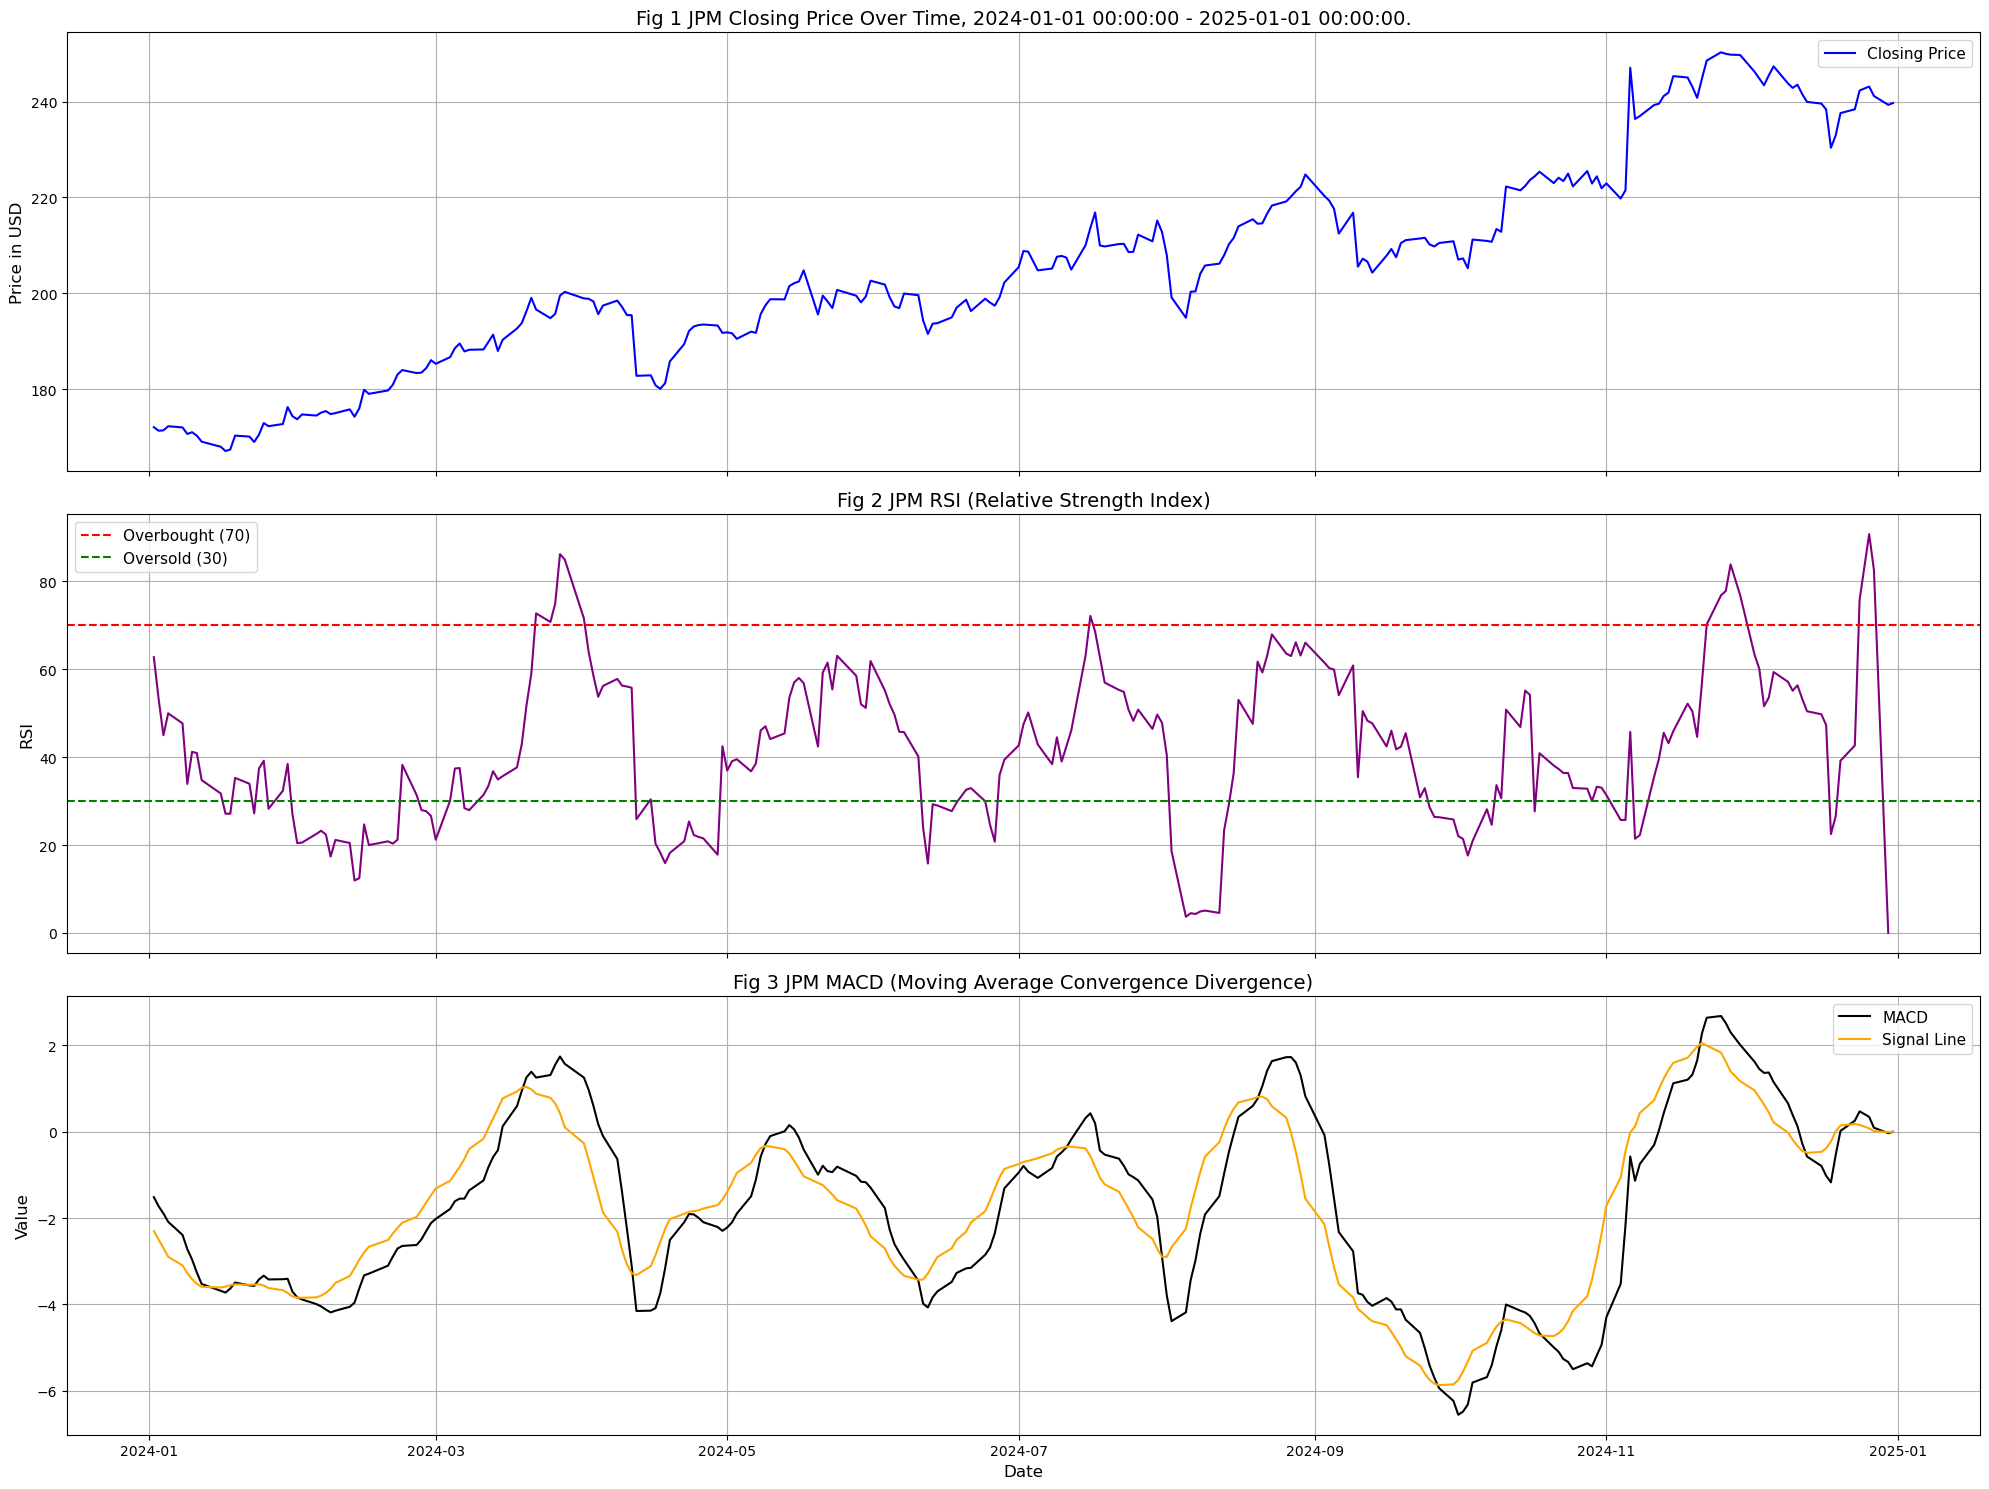

In [15]:
#Draws plot
plotter = StockPlotter(stock_data, ticker, start, end)
fig1_3 = plotter.plot()
pdf_pages.savefig(fig1_3)  # Save stock plot to PDF

Backtest results saved to backtest_results.xlsx
          Date    Open    High      Low   Close    Volume        RSI  \
0   2024-01-02  169.09  172.17  168.910  172.08   9977424  62.737016   
1   2024-01-03  171.86  172.04  170.370  171.33   9852335  53.219550   
2   2024-01-04  170.64  173.35  170.540  171.41  11972545  44.983607   
3   2024-01-05  171.47  173.38  171.470  172.27  10066029  49.966777   
4   2024-01-08  172.02  172.36  169.485  172.02  11229916  47.672131   
..         ...     ...     ...      ...     ...       ...        ...   
228 2024-11-26  250.50  251.00  248.340  249.97   6212142  77.815046   
229 2024-11-27  249.34  251.19  248.771  249.79   5472265  83.856346   
230 2024-11-29  249.92  251.77  249.445  249.72   5494825  76.858974   
231 2024-12-02  249.70  250.25  245.030  246.25   8899741  63.361137   
232 2024-12-03  248.23  249.04  244.630  244.82   6657694  60.132367   

         MACD    Signal    BB_upper  BB_middle    BB_lower  Position  \
0   -1.515990 -

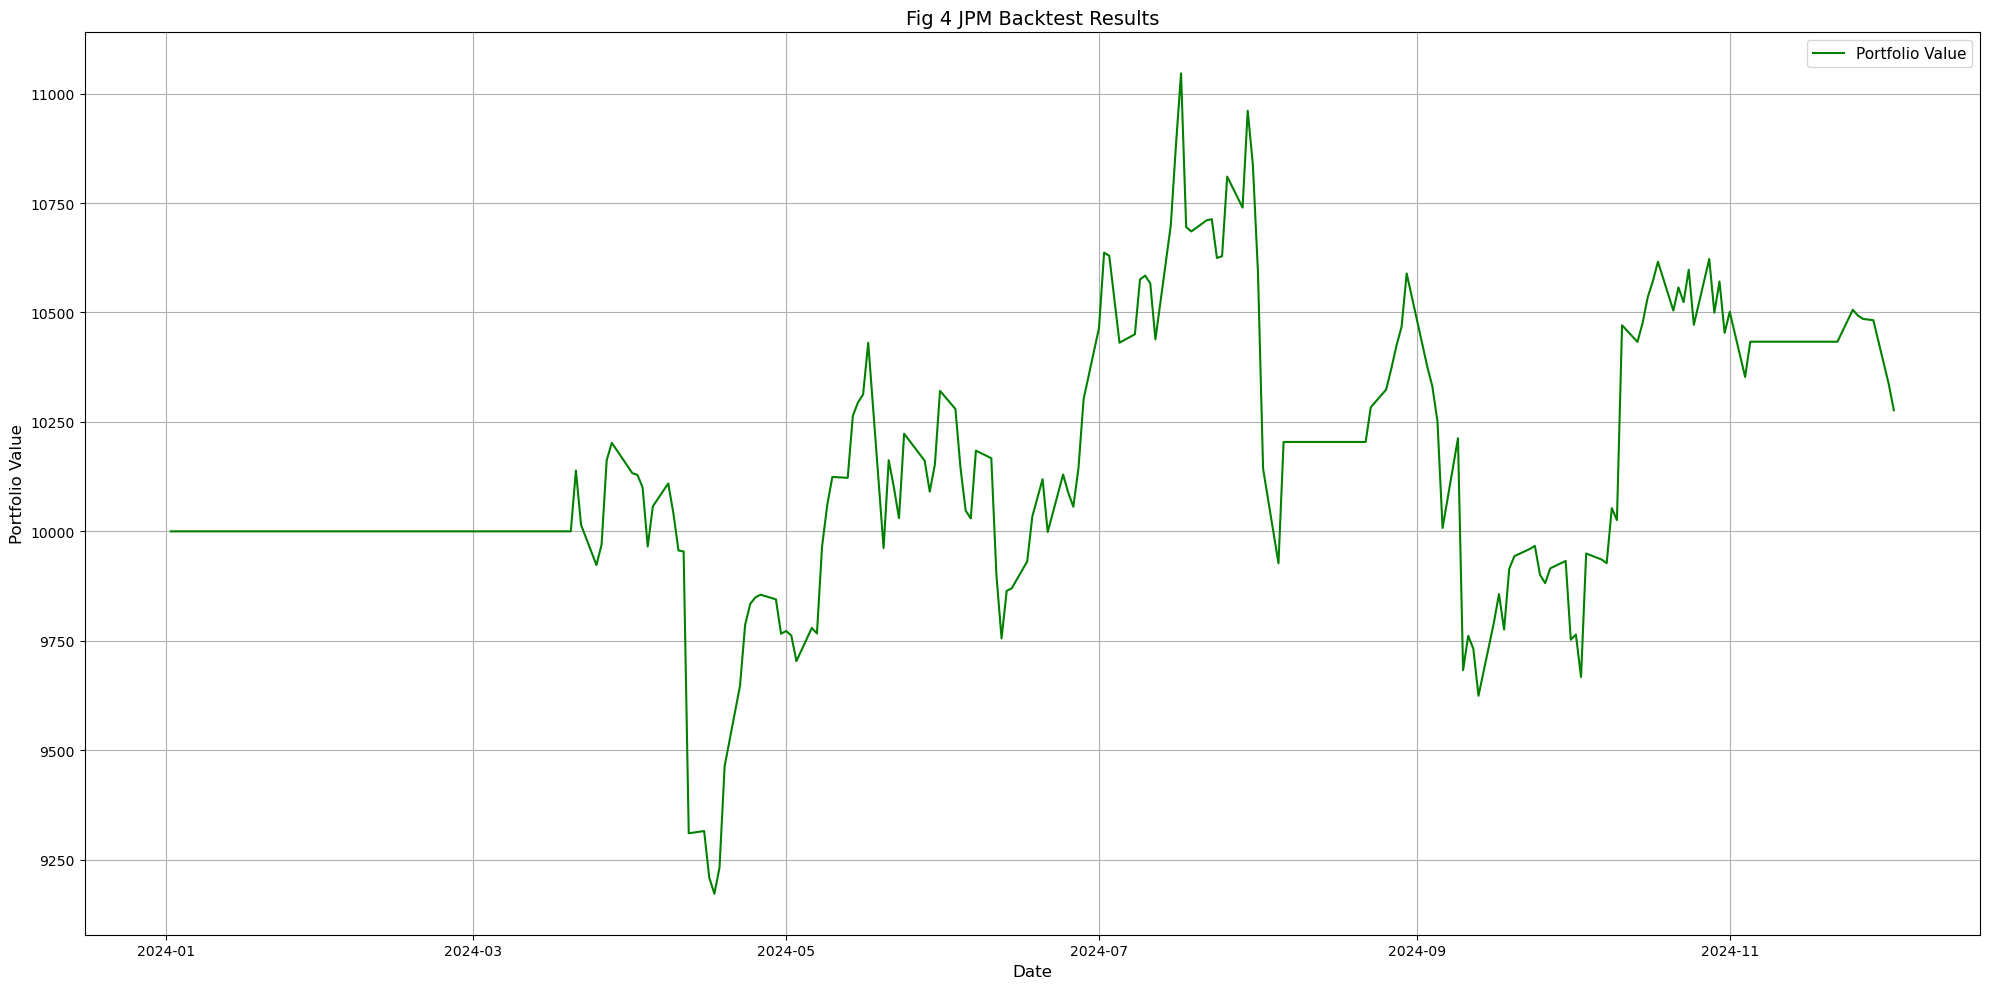

10276.604726831894


In [16]:
# Initialize Backtest Strategy
backtest_strategy = BacktestStrategy("Advanced Strategy", ticker)

# Generate backtest results
backtest_results = backtest_strategy.run_backtest(df, "Close")
print(backtest_results)

# Get the figure without showing it
fig4 = backtest_strategy.plot_backtest_results(backtest_results)

# Save the figure to PDF
pdf_pages.savefig(fig4)

# Now, show the plot only once
plt.show()

print(backtest_results["Portfolio Value"].iloc[-1])


In [17]:
portfolio_test_start = backtest_results.iloc[(-len(X_test)+1)]["Portfolio Value"]
date_test_start = backtest_results.iloc[-(len(X_test)+1)]["Date"]
print(portfolio_test_start)
print(date_test_start)

10053.042503178018
2024-10-07 00:00:00


In [18]:
print(df_scaled.shape)

(233, 12)


In [19]:
print(X.shape)

(199, 15, 11)


Reloading Tuner from lstm_tuner\lstm_hyperparameter_tuning\tuner0.json
neurons : 150
dropout : 0.3
optimizer : adam
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0803 - val_loss: 0.0356
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0251 - val_loss: 0.0428
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0126 - val_loss: 0.0018
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0115 - val_loss: 0.0019
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0053 - val_loss: 0.0170
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0048 - val_loss: 6.7342e-04
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 150)             │          97,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 833,855 (3.18 MB)

 Trainable params: 277,951 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,904 (2.12 MB)

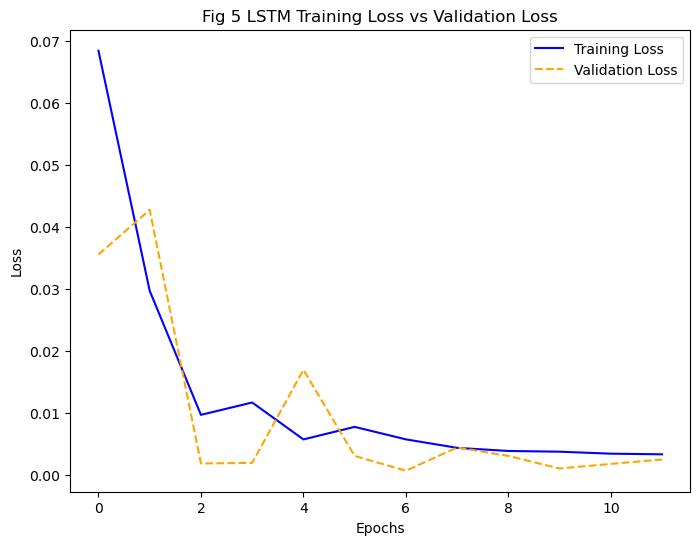

X_test shape: (40, 15, 11)


In [20]:
# Ensure correct feature dimension
n_features = X_train.shape[2]  # 11 features
lstm_model = Models.LSTM_Model(sequence_length, n_features)  # Initialize model

# Tune hyperparameters and create the model
best_params = lstm_model.tune_hyperparameters(X_train, y_train)

# Train the model and store training history
history_lstm = lstm_model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1)

# Ensure X_test is of the correct dtype
X_test = np.array(X_test, dtype=np.float32)

# Make predictions and flatten output
y_pred_lstm = lstm_model.predict(X_test).flatten()
lstm_model.summary()

# Create the plot
fig5, ax = plt.subplots(figsize=(8, 6))
ax.plot(history_lstm.history['loss'], label='Training Loss', color='blue')
ax.plot(history_lstm.history['val_loss'], label='Validation Loss', color='orange', linestyle='dashed')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Fig 5 LSTM Training Loss vs Validation Loss")

# Save the figure to PDF without closing
pdf_pages.savefig(fig5)

# Show the plot
plt.show()

print(f"X_test shape: {X_test.shape}")  # Check for consistent shape

In [24]:
print(df_scaled.shape)
# Assuming df_scaled is a pandas DataFrame
print(df_scaled.head())  # ✅ Check the structure


(233, 12)
          Date      Open      High       Low     Close    Volume       RSI  \
251 2024-01-02  0.049282  0.053469  0.054143  0.059976  0.184363  0.715775   
250 2024-01-03  0.081630  0.051971  0.071290  0.050962  0.179630  0.600423   
249 2024-01-04  0.067383  0.067066  0.073287  0.051923  0.259859  0.500602   
248 2024-01-05  0.077076  0.067412  0.084209  0.062260  0.187716  0.560999   
247 2024-01-08  0.083499  0.055658  0.060896  0.059255  0.231758  0.533187   

         MACD    Signal  BB_upper  BB_middle  BB_lower  
251  0.545698  0.450134  0.000000   0.000000  0.006868  
250  0.522932  0.425250  0.004358   0.001529  0.004969  
249  0.504854  0.400783  0.007753   0.003138  0.004339  
248  0.483879  0.375471  0.013006   0.005364  0.002830  
247  0.450918  0.349946  0.016625   0.006859  0.001711  


In [25]:
all_features = df.columns
print(all_features)
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
print(numeric_features)
features_10 = df.select_dtypes(include=['float64', 'int64']).drop(columns=["Close"]).columns
print(len(features_10))
print(features_10)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
       'Signal', 'BB_upper', 'BB_middle', 'BB_lower'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Signal',
       'BB_upper', 'BB_middle', 'BB_lower'],
      dtype='object')
10
Index(['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'Signal', 'BB_upper',
       'BB_middle', 'BB_lower'],
      dtype='object')


In [26]:
# ✅ Drop "Close" and "Date" to create X (features)
X = df.drop(columns=["Close", "Date"]).values  

# ✅ Set y (target) as "Close" column
y = df["Close"].values  

print(X.shape)
print(y.shape)
print(X)
print(y)

(233, 10)
(233,)
[[169.09       172.17       168.91       ... 175.11510109 170.8385
  166.56189891]
 [171.86       172.04       170.37       ... 175.48249303 170.9525
  166.42250697]
 [170.64       173.35       170.54       ... 175.76870171 171.0725
  166.37629829]
 ...
 [249.92       251.77       249.445      ... 250.88606308 241.629
  232.37193692]
 [249.7        250.25       245.03       ... 249.588101   241.109
  232.629899  ]
 [248.23       249.04       244.63       ... 248.92403802 240.782
  232.63996198]]
[172.08 171.33 171.41 172.27 172.02 170.66 171.02 170.3  169.05 167.99
 167.09 167.42 170.31 170.11 168.99 170.5  172.94 172.28 172.73 176.27
 174.36 173.73 174.73 174.5  175.1  175.43 174.8  175.01 175.79 174.26
 176.03 179.87 179.03 179.73 180.9  183.07 183.99 183.36 183.45 184.38
 186.06 185.29 186.68 188.55 189.53 187.87 188.22 188.29 189.84 191.38
 187.97 190.3  192.66 193.79 196.33 199.06 196.62 194.82 195.73 199.52
 200.3  198.94 198.86 198.3  195.65 197.45 198.48 197.15

Reshaping X_train from (159, 15, 11) to 2D
Final Test RMSE: 0.18809320874260463
[0.52676255 0.56834227 0.5854942  0.5956648  0.5955577  0.6078292
 0.6155929  0.6510636  0.6511514  0.65138686 0.64819044 0.64873815
 0.6517088  0.6498136  0.64419836 0.6440676  0.64168507 0.61542535
 0.6324549  0.61529315 0.61531675 0.63248855 0.63215584 0.632512
 0.6325061  0.629993   0.64973676 0.66928136 0.6693275  0.66939247
 0.6695044  0.6719148  0.6693045  0.6757703  0.6757954  0.6758606
 0.67834026 0.6758445  0.67552346 0.6755263 ]


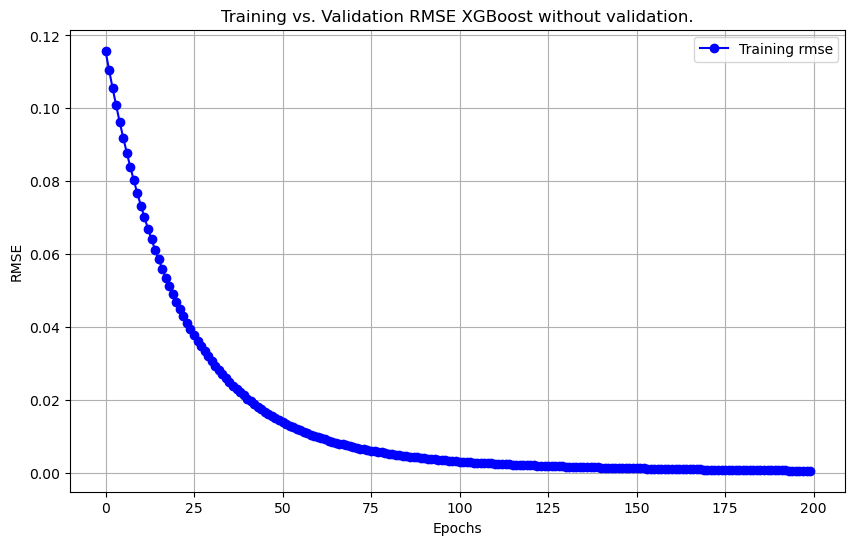

In [27]:
# Assuming X and y are your dataset features and target

xgb_model = XGBoostModel(n_estimators=200, max_depth=5, learning_rate=0.05)

xgb_model.fit(X_train, y_train, verbose=False)

xgb_model.evaluate(X_test, y_test)

y_pred_xgb = xgb_model.predict(X_test)
print(y_pred_xgb)

fig = xgb_model.plot_training_history()
plt.show()  



X_train_val shape: (163, 10)
X_val shape: (35, 10)
X_test_val shape: (35, 10)
Train columns: Index(['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'Signal', 'BB_upper',
       'BB_middle', 'BB_lower'],
      dtype='object')
Test columns: Index(['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'Signal', 'BB_upper',
       'BB_middle', 'BB_lower'],
      dtype='object')
163
35
[0]	train-rmse:17.52128	validation-rmse:23.10848
[1]	train-rmse:16.71505	validation-rmse:22.03312
[2]	train-rmse:15.94728	validation-rmse:21.01019
[3]	train-rmse:15.21593	validation-rmse:20.03337
[4]	train-rmse:14.51871	validation-rmse:19.09649
[5]	train-rmse:13.85449	validation-rmse:18.20648
[6]	train-rmse:13.22109	validation-rmse:17.36406
[7]	train-rmse:12.61785	validation-rmse:16.56029
[8]	train-rmse:12.04277	validation-rmse:15.80080
[9]	train-rmse:11.49507	validation-rmse:15.06476
[10]	train-rmse:10.97458	validation-rmse:14.32757
[11]	train-rmse:10.47700	validation-rmse:13.67814
[12]	train-rmse:10.00368	validat

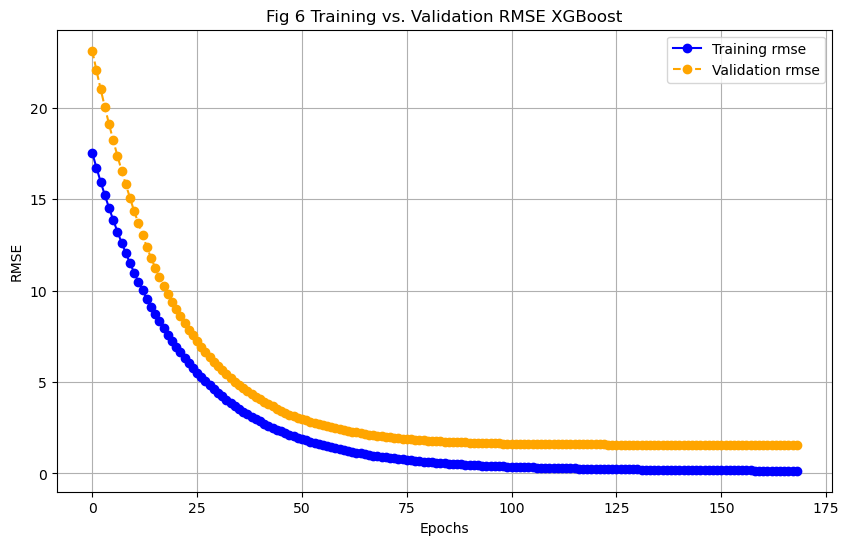

In [28]:
# Split data into train (70%), validation (15%), and test (15%)
X_train_val, X_temp, y_train_val, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test_val, y_val, y_test_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_val = pd.DataFrame(X_train_val, columns=features_10)  # Replace `feature_names` with actual feature names
X_test_val = pd.DataFrame(X_test_val, columns=features_10)

# Initialize the model with validation support
xgb_model_val = XGBoostModelVal(n_estimators=200, max_depth=5, learning_rate=0.05, early_stopping_rounds=10)


print("X_train_val shape:", X_train_val.shape)
print("X_val shape:", X_val.shape)
print("X_test_val shape:", X_test_val.shape)
print("Train columns:", X_train_val.columns)
print("Test columns:", X_test_val.columns)
print(len(X_train_val))
print(len(X_test_val))

# Fit the model using both training and validation data
xgb_model_val.fit(X_train_val, y_train_val, X_val=X_val, y_val=y_val, verbose=True)

# Evaluate the model on test data
xgb_model_val.evaluate(X_test_val, y_test_val)

# Make predictions
y_pred_xgb_val = xgb_model_val.predict(X_test_val)
print(y_pred_xgb_val)

# Plot training history including validation performance
fig6 = xgb_model_val.plot_training_history()
plt.show()

pdf_pages.savefig(fig6)

Without validation line because it requires addidional split of training data. Then the number of test data is different from other models. It makes the comparision less effective.

In [29]:
print(X_train.shape)
print(X_test.shape)

(159, 15, 11)
(40, 15, 11)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized Kernel: 316**2 * Matern(length_scale=5.3e+03, nu=1.5) + WhiteKernel(noise_level=1e-08)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized Kernel: 316**2 * Matern(length_scale=5.32e+03, nu=1.5) + WhiteKernel(noise_level=1e-08)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.w

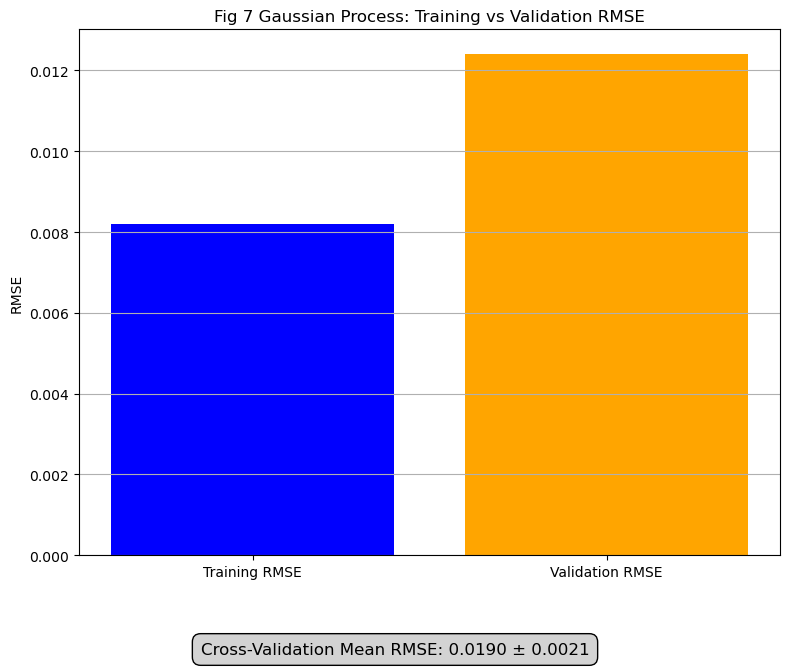

In [30]:
gp_model = Models.GP_Model()
gp_model.fit(X_train, y_train)

# Predict with confidence intervals
y_pred_gp, sigma_gp = gp_model.predict(X_test, return_std=True)
#gp_model = GaussianProcessModel()
fig7 = gp_model.validate(X_train, y_train)
pdf_pages.savefig(fig7) 

In [31]:
print(y_pred_lstm.shape)
print(y_pred_xgb.shape)
print(y_pred_gp.shape)

(40,)
(40,)
(40,)


In [32]:
print(X_test.shape)
print(y_test.shape)

(40, 15, 11)
(40,)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Model: LSTM
MSE: 0.0379
MAE: 0.1579
R²: 0.7932
Direction: 0.5542

Model: XGBoost
MSE: 0.0354
MAE: 0.1464
R²: -0.6845
Direction: 0.6154

Model: Gaussian Process
MSE: 0.0011
MAE: 0.0258
R²: 0.9483
Direction: 0.6667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
40


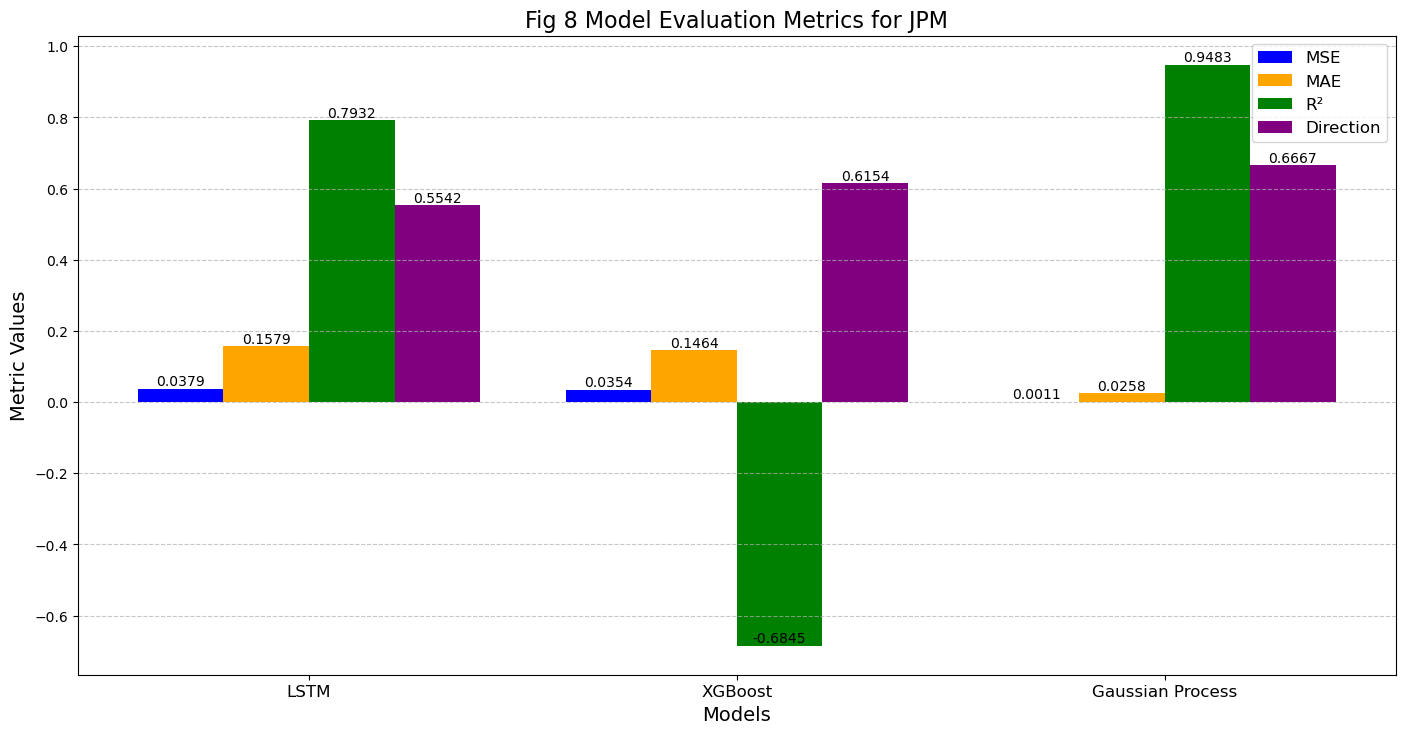

In [33]:
models = {
    'LSTM': lstm_model,
    'XGBoost': xgb_model,
    'Gaussian Process': y_pred_gp
}
'''models = {

    'XGBoost': xgb_model,
    'Gaussian Process': y_pred_gp
}'''
evaluator = ModelEvaluator(models, X_test, y_test, ticker)

# Evaluate models
evaluation_results, y_predictions = evaluator.evaluate()

# Print results
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

fig8 = evaluator.plot_metrics()
pdf_pages.savefig(fig8)
print(len(X_test))

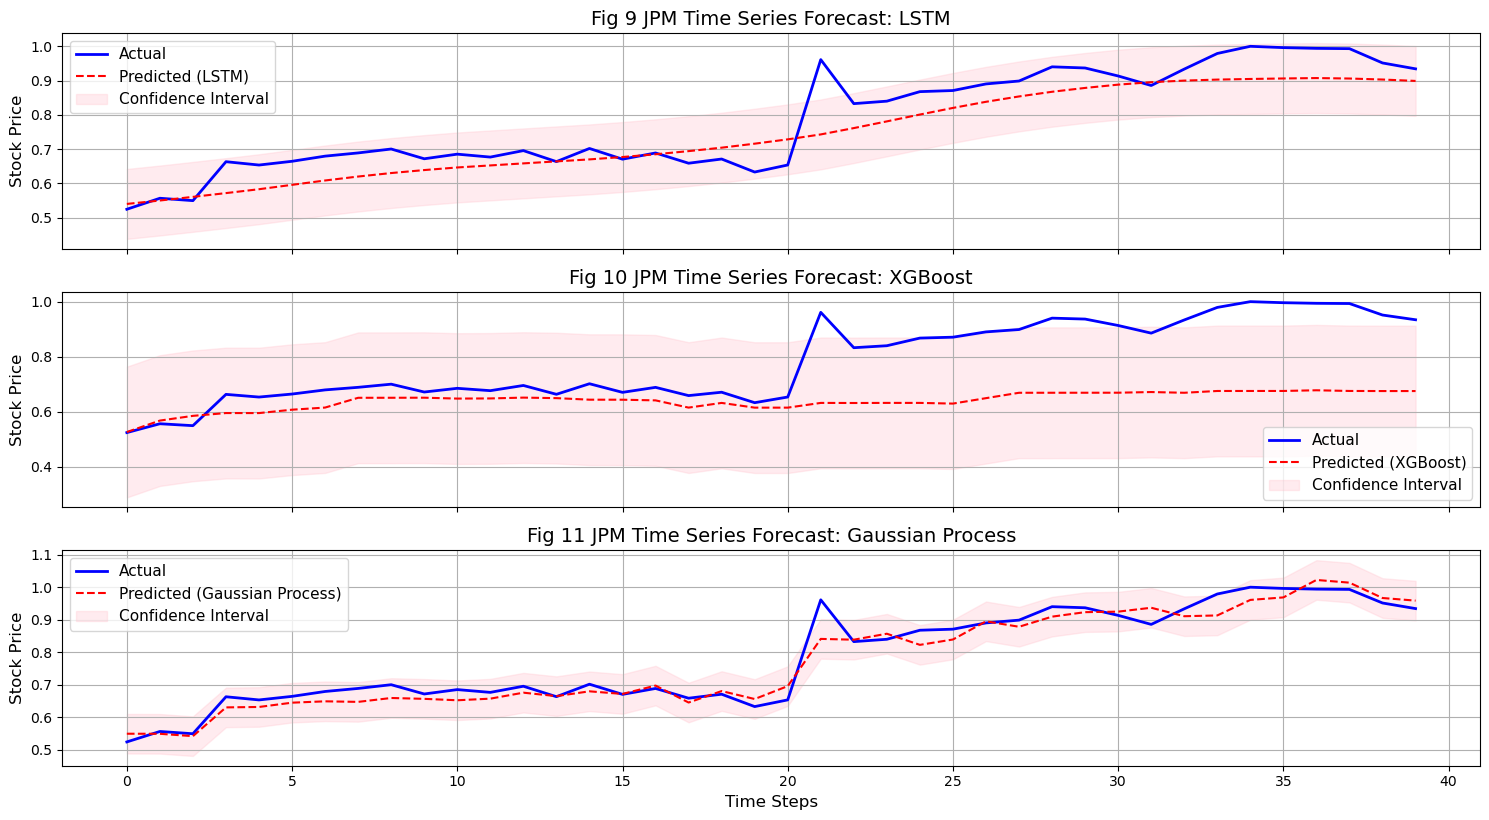

In [34]:
std_devs = {}  # Ensure std_devs exists even if sigma_gp is not available

if 'sigma_gp' in globals():
    std_devs['GP'] = sigma_gp  # Add Gaussian Process std deviation if available# Assuming you have predictions from LSTM, XGBoost, and Gaussian Process
    
predictions = {
    'LSTM': y_pred_lstm,
    'XGBoost': y_pred_xgb,
    'Gaussian Process': y_pred_gp
} 

'''predictions = {
    'XGBoost': y_pred_xgb,
    'Gaussian Process': y_pred_gp
}'''
if 'sigma_gp' in globals():
    std_devs = {'GP': sigma_gp}

visualizer = TimeSeriesVisualizer(y_test, predictions, ticker, std_devs)

fig9_11 = visualizer.plot_predictions()
pdf_pages.savefig(fig9_11)

In [35]:
# Close the PDF file
pdf_pages.close()
print(f"PDF successfully closed")

#Falls nur ein Teil von Code wird ausgefuert und kein pdf erzeugt wird, sonst Fehlermeldung
pdf_pages = PdfPages("output.pdf")

if pdf_pages.get_pagecount() > 0:  # Direkter Vergleich ohne len()
    pdf_pages.close()
else:
    pdf_pages._file.close()  # Datei korrekt schließen, um die Warnung zu vermeiden

PDF successfully closed


In [36]:
# Define file paths
main_pdf = pdf_path  # The PDF created in your code
extra_pdf = "text_fig.pdf"  # The external PDF you want to add
output_pdf = pdf_path  # The final merged output

# Ensure the files exist
if not os.path.exists(main_pdf):
    print(f"Error: {main_pdf} does not exist.")
    exit()
if not os.path.exists(extra_pdf):
    print(f"Error: {extra_pdf} does not exist.")
    exit()

# Open both PDFs
reader_main = PdfReader(main_pdf)
reader_extra = PdfReader(extra_pdf)
writer = PdfWriter()

# Copy all pages from the main PDF
for page in reader_main.pages:
    writer.add_page(page)

# Append all pages from the extra PDF
for page in reader_extra.pages:
    writer.add_page(page)

# Save the final merged PDF
with open(output_pdf, "wb") as output_file:
    writer.write(output_file)

print(f"Successfully merged! Final PDF saved as: {output_pdf}")


Successfully merged! Final PDF saved as: results/results_JPM_2024-01-01_to_2025-01-01.pdf
